In [1]:
import os
import sys
from typing import List
from tqdm import tqdm
import numpy as np

# for parent directory imports (source)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch

import torch
import torch.nn as nn

import torchvision as tv
from torchvision import datasets

from torch.utils.data import Subset, Dataset, ConcatDataset, DataLoader

from source.constants import DATASETS_PATH
from source.utils.seeding import fix_seeds
from source.utils.train_utils import fit
from source.utils.metrics import accuracy, aod, eod, spd, get_prs, get_tprs, get_fprs

/system/apps/userenv/kschweig/quam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fix_seeds(42)

transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5,), (0.5,))
])

# Download the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root=DATASETS_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=DATASETS_PATH, train=False, download=True, transform=transform)

# split the training dataset into training and validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

100%|██████████| 26421880/26421880 [00:01<00:00, 15474109.88it/s]


Extracting /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2501412.05it/s]

Extracting /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 17840856.73it/s]


Extracting /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26236059.53it/s]

Extracting /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /system/user/publicwork/kschweig/disparate-benefits/datasets/FashionMNIST/raw



50000 10000 10000


9893


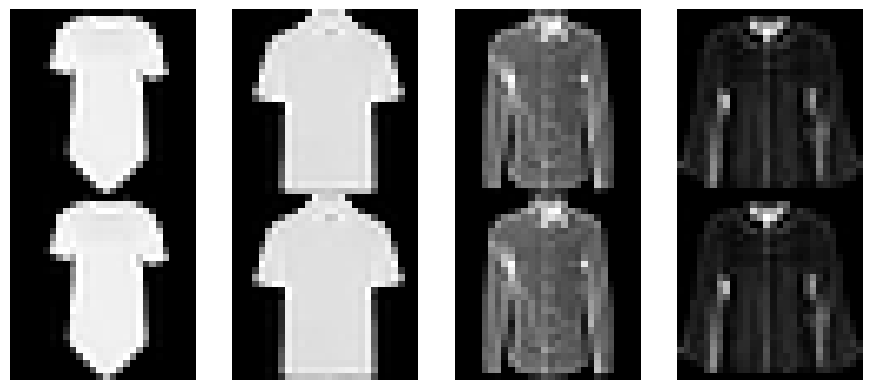

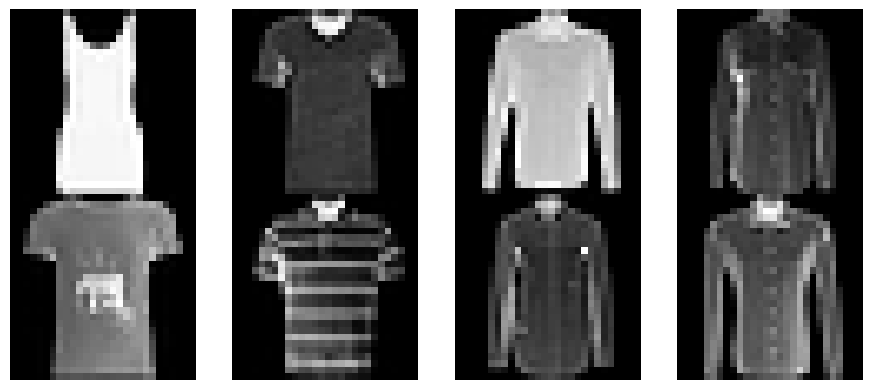

In [3]:
class ConcatenateFMNIST(Dataset):
    # 0 (T-shirt/top), 1 (Trouser), 2 (Pullover), 3 (Dress), 4 (Coat), 5 (Sandal), 6 (Shirt), 7 (Sneaker), 8 (Bag), 9 (Ankle boot)
    def __init__(self, dataset, same_image = True, used_classes = [0, 6]): # alternative is [2, 4]
        self.dataset = dataset
        self.same_image = same_image
        self.same_label_indices = [0] * 10
        for label in range(10):
            if isinstance(self.dataset, Subset):
                self.same_label_indices[label] = torch.where(self.dataset.dataset.targets[self.dataset.indices] == label)[0]
            else:
                self.same_label_indices[label] = torch.where(self.dataset.targets == label)[0]
        

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.same_image:
            concatenated_image = torch.cat((image, image), dim=1)
        else:
            # randomly select another image with the same label
            random_index = torch.randint(0, len(self.same_label_indices[label]), (1,))
            random_index = self.same_label_indices[label][random_index]
            random_image, _ = self.dataset[random_index.item()]
            concatenated_image = torch.cat((image, random_image), dim=1)
        return concatenated_image, label

    def __len__(self):
        return len(self.dataset)
    
class LabelSubset(Dataset):
    # 0 (T-shirt/top), 1 (Trouser), 2 (Pullover), 3 (Dress), 4 (Coat), 5 (Sandal), 6 (Shirt), 7 (Sneaker), 8 (Bag), 9 (Ankle boot)
    def __init__(self, dataset, used_classes = [0, 6]): # alternative is [2, 4]
        self.dataset = dataset
        self.used_classes = used_classes
        self.indices = []
        for label in used_classes:
            if isinstance(self.dataset, ConcatenateFMNIST):
                dataset = self.dataset.dataset
            if isinstance(dataset, Subset):
                self.indices += torch.where(dataset.dataset.targets[dataset.indices] == label)[0].tolist()
            else:
                self.indices += torch.where(dataset.targets == label)[0].tolist()

    def __getitem__(self, index):
        image, label = self.dataset[self.indices[index]]
        return image, self.used_classes.index(label)
    
    def __len__(self):
        return len(self.indices)
    

# create dataset and visualize 
train_dataset_ = LabelSubset(ConcatenateFMNIST(train_dataset, same_image=True))

print(len(train_dataset_))

# visualize the dataset
fig, axs = plt.subplots(1, 4, figsize=(11, 5))
for i in range(4):
    image, label = train_dataset_[i * 2000 + 2000]
    axs[i].imshow(image.permute(1, 2, 0), cmap="gray")	
    # axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")
plt.savefig("concatenated_fmnist_same_image.png")

# create dataset and visualize 
train_dataset_ = LabelSubset(ConcatenateFMNIST(train_dataset, same_image=False))

# visualize the dataset
fig, axs = plt.subplots(1, 4, figsize=(11, 5))
for i in range(4):
    image, label = train_dataset_[i * 2000 + 2002]
    axs[i].imshow(image.permute(1, 2, 0), cmap="gray")
    # axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")
plt.savefig("concatenated_fmnist_different_image.png")

In [4]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 7, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 14 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class GroupDataset(Dataset):
    def __init__(self, dataset1, dataset2, yield_group = False):
        self.dataset = ConcatDataset([dataset1, dataset2])
        self.cutoff = len(dataset1)
        self.yield_group = yield_group

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.yield_group:
            return image, torch.tensor(label, dtype=torch.long), torch.tensor(int(index >= self.cutoff), dtype=torch.long)
        return image, torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.dataset)

In [10]:
batch_size = 1024
lr = 1e-3
epochs = 10
weight_decay = 1e-5

device = "cuda:0"

n_models = 10

method_seeds = [42, 142, 242, 342, 442]

In [6]:
# create ensemble of 10 models
ensemble = [SmallCNN() for _ in range(n_models * len(method_seeds))]

In [7]:
rng = np.random.default_rng(seed=42)

# get index for random subset
indices = rng.choice(np.arange(len(LabelSubset(train_dataset))), size=len(LabelSubset(train_dataset)) // 2, replace=False)
remaining_indices = np.delete(np.arange(len(LabelSubset(train_dataset))), (indices))

train_dataset = GroupDataset(Subset(LabelSubset(ConcatenateFMNIST(train_dataset, same_image=True)), indices),
                             Subset(LabelSubset(ConcatenateFMNIST(train_dataset, same_image=False)), remaining_indices))

# get index for random subset
indices = rng.choice(np.arange(len(LabelSubset(val_dataset))), size=len(LabelSubset(val_dataset)) // 2, replace=False)
remaining_indices = np.delete(np.arange(len(LabelSubset(val_dataset))), (indices))

val_dataset = GroupDataset(Subset(LabelSubset(ConcatenateFMNIST(val_dataset, same_image=True)), indices),
                           Subset(LabelSubset(ConcatenateFMNIST(val_dataset, same_image=False)), remaining_indices))

# get index for random subset
indices = rng.choice(np.arange(len(LabelSubset(test_dataset))), size=len(LabelSubset(test_dataset)) // 2, replace=False)
remaining_indices = np.delete(np.arange(len(LabelSubset(test_dataset))), (indices))

test_dataset = GroupDataset(Subset(LabelSubset(ConcatenateFMNIST(test_dataset, same_image=True)), indices),
                            Subset(LabelSubset(ConcatenateFMNIST(test_dataset, same_image=False)), remaining_indices))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

img, label = next(iter(train_loader))
print(img.shape, label.shape)

torch.Size([1024, 1, 56, 28]) torch.Size([1024])


In [8]:
for m, model in enumerate(ensemble):
    model = model.to(device)
    model = fit(model, train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)[0]
    # save the model
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), os.path.join("models", f"small_cnn_{m}.pt"))

Train loss 0.2277, val performance: 89.80%: 100%|██████████| 10/10 [01:10<00:00,  7.08s/it]


In [11]:
# load models
ensemble = [SmallCNN() for _ in range(n_models * len(method_seeds))]
for m, model in enumerate(ensemble):
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join("models", f"small_cnn_{m}.pt"), map_location=device))
    model.eval()

In [12]:
@torch.no_grad()
def evaluate(networks: List, ds: Dataset):
    probits = list()
    for network in tqdm(networks):
        network.eval()
        probits_ = list()
        for x, _ in DataLoader(ds, batch_size = batch_size, shuffle=False, drop_last=False):
            x = x.to(device)

            probits_.append(torch.softmax(network.forward(x), dim=1).cpu())
        probits_ = torch.concat(probits_, dim=0)
        probits.append(probits_)
    return torch.stack(probits, dim=0)

test_probits = evaluate(ensemble, test_dataset)

print(test_probits.shape)

test_probits = test_probits.reshape(len(method_seeds), n_models, -1, 2)

print(test_probits.shape)

torch.save(test_probits, f"test_probits.pt")

100%|██████████| 50/50 [01:04<00:00,  1.29s/it]

torch.Size([50, 2000, 2])
torch.Size([5, 10, 2000, 2])


In [13]:
test_dataset.yield_group = True

y_test_t, a_test_t = list(), list()

for _, y, a in DataLoader(test_dataset, batch_size = batch_size, shuffle=False, drop_last=False):
    y_test_t.append(y)
    a_test_t.append(a)

y_test_t = torch.cat(y_test_t, dim=0)
a_test_t = torch.cat(a_test_t, dim=0)

p_a_test = a_test_t.float().mean().item() * 100
p_y_test = y_test_t.float().mean().item() * 100

print(y_test_t.shape, a_test_t.shape)

test_dataset.yield_group = False

torch.Size([2000]) torch.Size([2000])


In [14]:
from matplotlib import patches
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

torch.Size([5, 10, 2000, 2])


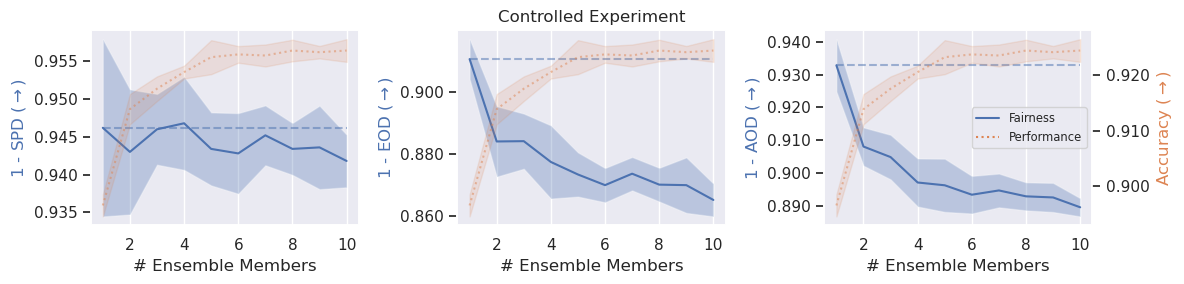

In [22]:
ensemble_members = list(range(1, len(test_probits[1]) + 1))

print(test_probits.shape)

test_fm_aurocs, test_fm_spds, test_fm_eods, test_fm_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):

    test_fm_aurocs_, test_fm_spds_, test_fm_eods_, test_fm_aods_ = list(), list(), list(), list()

    for em in ensemble_members:
        preds = torch.mean(test_probits[m, :em], dim=0)
        preds = preds.argmax(dim=1)
        test_fm_aurocs_.append(accuracy(preds, y_test_t))
        test_fm_spds_.append(1 - spd(preds, a_test_t))
        test_fm_eods_.append(1 - eod(preds, y_test_t, a_test_t))
        test_fm_aods_.append(1 - aod(preds, y_test_t, a_test_t))

    test_fm_aurocs.append(test_fm_aurocs_)
    test_fm_spds.append(test_fm_spds_)
    test_fm_eods.append(test_fm_eods_)
    test_fm_aods.append(test_fm_aods_)

test_fm_aurocs = np.asarray(test_fm_aurocs)
test_fm_spds = np.asarray(test_fm_spds)
test_fm_eods = np.asarray(test_fm_eods)
test_fm_aods = np.asarray(test_fm_aods)

f, axs = plt.subplots(1, 3, figsize=(12, 3))

acc_axs = list()
for ax in axs:
    acc_axs.append(ax.twinx())

axs[0].plot(ensemble_members, np.mean(test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                       np.mean(test_fm_spds, axis=0) - np.std(test_fm_spds, axis=0), 
                       np.mean(test_fm_spds, axis=0) + np.std(test_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(test_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(test_fm_eods, axis=0), "-", zorder=3)
axs[1].fill_between(ensemble_members, 
                       np.mean(test_fm_eods, axis=0) - np.std(test_fm_eods, axis=0), 
                       np.mean(test_fm_eods, axis=0) + np.std(test_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(test_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members, 
                       np.mean(test_fm_aods, axis=0) - np.std(test_fm_aods, axis=0), 
                       np.mean(test_fm_aods, axis=0) + np.std(test_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(test_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(test_fm_aurocs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(test_fm_aurocs, axis=0) - np.std(test_fm_aurocs, axis=0), 
                    np.mean(test_fm_aurocs, axis=0) + np.std(test_fm_aurocs, axis=0), alpha=0.15, color="C1")
    
axs[1].set_title("Controlled Experiment")

for ax in axs.flatten():
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="center right", fontsize="x-small")
f.tight_layout()
plt.savefig(os.path.join(f"controlled_experiment_main.pdf"))
plt.show()

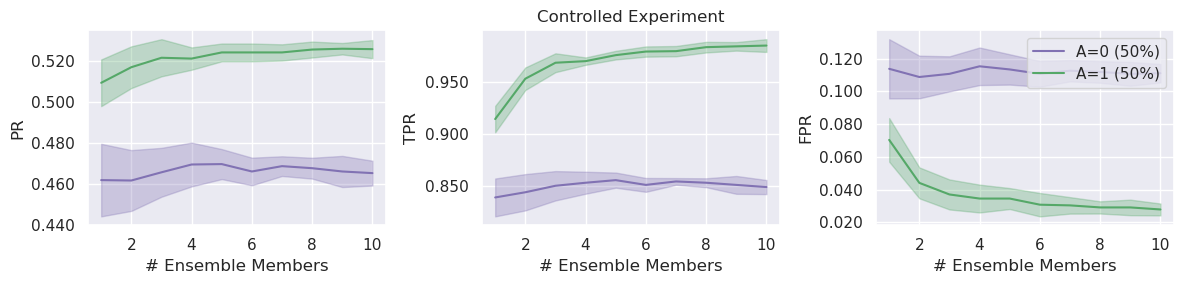

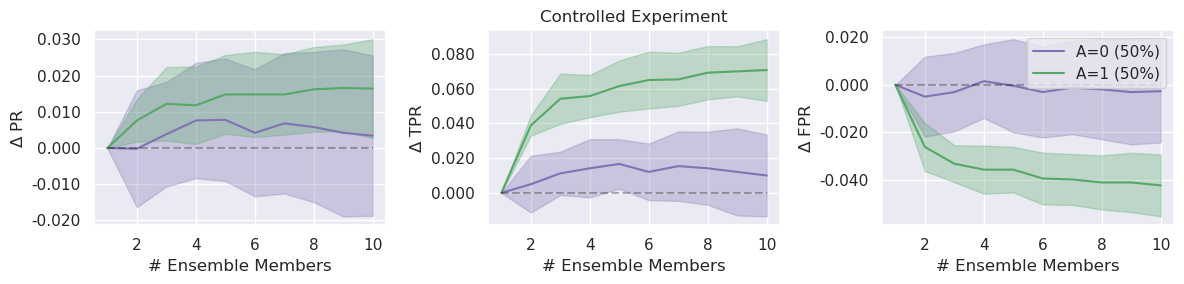

In [15]:
ensemble_members = list(range(1, len(test_probits[0]) + 1))

for delta in [False, True]:

    test_fm_prs_1, test_fm_prs_0 = list(), list()
    test_fm_tprs_1, test_fm_tprs_0 = list(), list()
    test_fm_fprs_1, test_fm_fprs_0 = list(), list()
    

    for m in range(len(method_seeds)):

        test_fm_prs_1_, test_fm_prs_0_ = list(), list()
        test_fm_tprs_1_, test_fm_tprs_0_ = list(), list()
        test_fm_fprs_1_, test_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(test_probits[m, :em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_test_t)
            tpr1, tpr0 = get_tprs(preds, y_test_t, a_test_t)
            fpr1, fpr0 = get_fprs(preds, y_test_t, a_test_t)
            test_fm_prs_1_.append(pr1)
            test_fm_prs_0_.append(pr0)
            test_fm_tprs_1_.append(tpr1)
            test_fm_tprs_0_.append(tpr0)
            test_fm_fprs_1_.append(fpr1)
            test_fm_fprs_0_.append(fpr0)
            
        if delta:
            test_fm_prs_1.append([t - test_fm_prs_1_[0] for t in test_fm_prs_1_])
            test_fm_prs_0.append([t - test_fm_prs_0_[0] for t in test_fm_prs_0_])
            test_fm_tprs_1.append([t - test_fm_tprs_1_[0] for t in test_fm_tprs_1_])
            test_fm_tprs_0.append([t - test_fm_tprs_0_[0] for t in test_fm_tprs_0_])
            test_fm_fprs_1.append([t - test_fm_fprs_1_[0] for t in test_fm_fprs_1_])
            test_fm_fprs_0.append([t - test_fm_fprs_0_[0] for t in test_fm_fprs_0_])

        else:
            test_fm_prs_1.append(test_fm_prs_1_)
            test_fm_prs_0.append(test_fm_prs_0_)
            test_fm_tprs_1.append(test_fm_tprs_1_)
            test_fm_tprs_0.append(test_fm_tprs_0_)
            test_fm_fprs_1.append(test_fm_fprs_1_)
            test_fm_fprs_0.append(test_fm_fprs_0_)

    test_fm_prs_1 = np.asarray(test_fm_prs_1)
    test_fm_prs_0 = np.asarray(test_fm_prs_0)
    test_fm_tprs_1 = np.asarray(test_fm_tprs_1)
    test_fm_tprs_0 = np.asarray(test_fm_tprs_0)
    test_fm_fprs_1 = np.asarray(test_fm_fprs_1)
    test_fm_fprs_0 = np.asarray(test_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([test_fm_prs_0, test_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_test if t == 1 else 100 - p_a_test):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ PR" if delta else "PR")
    for t, test_pr in enumerate([test_fm_tprs_0, test_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_test if t == 1 else 100 - p_a_test):.0f}%)")
        axs[1].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ TPR" if delta else "TPR")
    for t, test_pr in enumerate([test_fm_fprs_0, test_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_test if t == 1 else 100 - p_a_test):.0f}%)")
        axs[2].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ FPR" if delta else "FPR")
    axs[2].legend(loc="upper right")

    axs[1].set_title("Controlled Experiment")

    for ax in axs:
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(f"controlled_experiment_delta_rates.pdf"))
    else:
        plt.savefig(os.path.join(f"controlled_experiment_rates.pdf"))
    plt.show()

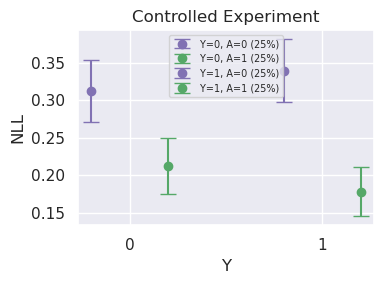

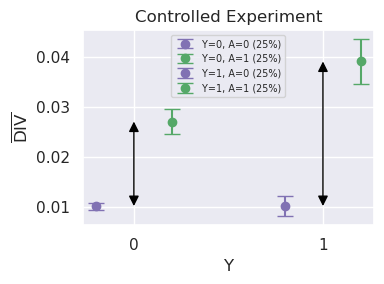

In [19]:
test_member_loss_y0_a1, test_member_loss_y1_a1, test_member_loss_y0_a0, test_member_loss_y1_a0 = list(), list(), list(), list()
test_member_loss_a1, test_member_loss_a0 = list(), list()
test_ensemble_loss_y0_a1, test_ensemble_loss_y1_a1, test_ensemble_loss_y0_a0, test_ensemble_loss_y1_a0 = list(), list(), list(), list()
test_ensemble_loss_a1, test_ensemble_loss_a0 = list(), list()

preds = test_probits
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

test_member_loss_y1_a1 = member_loss[..., (y_test_t == 1) & (a_test_t == 1)].mean(dim=2).reshape(1, -1)
test_member_loss_y0_a1 = member_loss[..., (y_test_t == 0) & (a_test_t == 1)].mean(dim=2).reshape(1, -1)
test_member_loss_y1_a0 = member_loss[..., (y_test_t == 1) & (a_test_t == 0)].mean(dim=2).reshape(1, -1)
test_member_loss_y0_a0 = member_loss[..., (y_test_t == 0) & (a_test_t == 0)].mean(dim=2).reshape(1, -1)
test_member_loss_a1 = member_loss[..., a_test_t == 1].mean(dim=2).reshape(1, -1)
test_member_loss_a0 = member_loss[..., a_test_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2, 
#                                          index=y_test_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                         index=y_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]
test_ensemble_loss_y1_a1 = ensemble_loss[..., (y_test_t == 1) & (a_test_t == 1)].mean(dim=1).reshape(1, -1)
test_ensemble_loss_y0_a1 = ensemble_loss[..., (y_test_t == 0) & (a_test_t == 1)].mean(dim=1).reshape(1, -1)
test_ensemble_loss_y1_a0 = ensemble_loss[..., (y_test_t == 1) & (a_test_t == 0)].mean(dim=1).reshape(1, -1)
test_ensemble_loss_y0_a0 = ensemble_loss[..., (y_test_t == 0) & (a_test_t == 0)].mean(dim=1).reshape(1, -1)
test_ensemble_loss_a1 = ensemble_loss[..., a_test_t == 1].mean(dim=1).reshape(1, -1)
test_ensemble_loss_a0 = ensemble_loss[..., a_test_t == 0].mean(dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([test_member_loss_y0_a0, test_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_test) * (p_a_test if t == 1 else 100 - p_a_test) / 100):.0f}%)")
for t, test_ent in enumerate([test_member_loss_y1_a0, test_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_test * (p_a_test if t == 1 else 100 - p_a_test) / 100):.0f}%)")
# for t, test_ent in enumerate([test_ensemble_loss_y0_a0, test_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([test_ensemble_loss_y1_a0, test_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("Controlled Experiment")
plt.ylabel("NLL")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_test if t == 1 else 100 - p_a_test):.0f}%)") for t in range(2)])
plt.legend(fontsize="xx-small", loc="upper center")
plt.tight_layout()
plt.savefig(f"controlled_experiment_likelihood.pdf")
plt.show()


# YA difference
test_member_loss_y0_a0 = torch.mean(test_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
test_member_loss_y0_a1 = torch.mean(test_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
test_member_loss_y1_a0 = torch.mean(test_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
test_member_loss_y1_a1 = torch.mean(test_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))
test_ents_y0 = [test_member_loss_y0_a0 - test_ensemble_loss_y0_a0, test_member_loss_y0_a1 - test_ensemble_loss_y0_a1]
for t, test_ent in enumerate(test_ents_y0):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_test) * (p_a_test if t == 1 else 100 - p_a_test) / 100):.0f}%)")
test_ents_y1 = [test_member_loss_y1_a0 - test_ensemble_loss_y1_a0, test_member_loss_y1_a1 - test_ensemble_loss_y1_a1]
for t, test_ent in enumerate(test_ents_y1):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_test * (p_a_test if t == 1 else 100 - p_a_test) / 100):.0f}%)")
ylims = plt.gca().get_ylim()
arrow = FancyArrowPatch((0, torch.mean(test_ents_y0[1][0], dim=0)), 
                        (0, torch.mean(test_ents_y0[0][0], dim=0)), 
                        arrowstyle='<|-|>', 
                        color='black', 
                        mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((1, torch.mean(test_ents_y1[1][0], dim=0)), 
                        (1, torch.mean(test_ents_y1[0][0], dim=0)), 
                        arrowstyle='<|-|>', 
                        color='black', 
                        mutation_scale=15, shrinkA=0, shrinkB=0)
plt.gca().add_patch(arrow)
plt.ylim(ylims)
plt.title("Controlled Experiment")
plt.ylabel("$\\overline{\mathrm{DIV}}$")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
plt.legend(fontsize="xx-small", loc="upper center")
plt.tight_layout()
plt.savefig(f"controlled_experiment_likelihood_ratio.pdf")
plt.show()